<a href="https://colab.research.google.com/github/stxupengyu/CNN-Long-Term-Prediction/blob/main/long_term_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#挂载云盘 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Project/天气数据')
!ls

Algorithm_Comparision.ipynb  bpnn_model_y2.h5	      lstm_model_y1.h5
best_model.h5		     cnn_model_y1.h5	      lstm_model_y2.h5
bpnn_long_term_model.h5      cnn_model_y2.h5	      y1_result.csv
bpnn_long_term_model_y2.h5   long_term_model_y1.h5    y1_result.gsheet
bpnn_model.h5		     long_term_model_y2.h5    y2_result.csv
bpnn_model_y1.h5	     long_term_predict.ipynb  天气数据.xlsx


#1 读取数据，预测y1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.layers import *
from keras.models import *
from keras.optimizers import Adam
from keras.models import load_model
import keras.backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
plt.style.use('seaborn')
#plt.style.use('bmh')
#plt.style.use('classic')
np.random.seed(100)

#设置参数
choose_y=1#选择预测第几个标签
window=12#时间窗长度
label_dim=50#标签维度-----------------------------------
epoch=20#迭代次数
batch_size=128#批处理数量
validation_split=.1#验证集比例
dense_unit=16#全连接层神经元数量
filters=16#cnn filter个数
kernel_size=1#cnn kernel个数
dropout = 0.1

def choose(choose_y):
  if choose_y==1:
    return 2
  if choose_y==2:
    return 1
def read_data():
  data=pd.read_excel('天气数据.xlsx',header=0) 
  data=data.iloc[:,1:-1]
  data.drop([data.columns[-choose(choose_y)]],axis=1,inplace=True) #删掉不选择的标签的列 
  label=data.iloc[:,-1]#为了反归一化
  label=np.reshape(label.values, (-1,1)) 
  print('The Data:\n',data.tail())
  y_show=data.values[-100:,-1]
  #归一化
  mm_x= MinMaxScaler()
  mm_y= MinMaxScaler()
  data= mm_x.fit_transform(data)
  label= mm_y.fit_transform(label)
  #根据原始数据集构建符合神经网络的数据集
  feature_num = data.shape[1]-1
  data_length=data.shape[0]
  x=[]
  y=[]
  for index in range(data_length - window-label_dim+1):
      x.append(data[index+1: index + window+1,:-1])
      y.append(data[index +window:index +window+label_dim ,-1])
  x = np.array(x)
  y = np.array(y)
  x_test=data[-window:,:-1]
  x_test=np.array([x_test])
  print('数据集长度：',data_length)
  print('数据集shape：',x.shape,y.shape,x_test.shape,y_show.shape)
  return x,y,x_test,y_show,feature_num,mm_y
x,y,x_test,y_show,feature_num,mm_y=read_data()

The Data:
       降水量(0.1mm)  平均气压(0.1hPa)  平均相对湿度(1%)  ...  日最低气温(0.1℃)  平均风速(0.1m/s)  so2
2216         0.0         10282          69  ...           22            19   10
2217         0.0         10255          80  ...           -8            14   10
2218        20.0         10208          85  ...          102            21    8
2219         0.0         10269          81  ...           58            20   10
2220         0.0         10376          60  ...            2            35    6

[5 rows x 7 columns]
数据集长度： 2221
数据集shape： (2160, 12, 6) (2160, 50) (1, 12, 6) (100,)


##1.1 建立CNN模型

In [ ]:
def cnn_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  cnn1=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs)#卷积层
  cnn1=MaxPooling1D(pool_size = window)(cnn1)#池化层
  dense=Dropout(dropout)(cnn1)#droupout层
  outputs=Lambda(lambda x:K.squeeze(x, axis=1))(dense)
  outputs = Dense(1, activation='relu')(outputs)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model
def long_term_model():
  #建立神经网络模型
  inputs=Input(shape=(window, feature_num))
  cnn1=Conv1D(filters = filters, kernel_size = kernel_size, activation = 'relu')(inputs)#卷积层
  cnn1=MaxPooling1D(pool_size = window)(cnn1)#池化层
  dense=Dropout(dropout)(cnn1)#droupout层
  dense=Dense(dense_unit, activation='relu')(dense)
  outputs = Dense(label_dim, activation='relu')(dense)
  model = Model(inputs=inputs, outputs=outputs)
  model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
  model.summary()#展示模型结构
  return model
def train_model(x,y):  
  #保存最好的模型
  es = EarlyStopping(monitor='val_loss', patience=2)
  cp = ModelCheckpoint(filepath=save_model, monitor='val_loss', save_best_only=True)
  history = myModel.fit(x=x,
                        y=y,
                        batch_size=batch_size,
                        epochs=epoch,
                        verbose=2,callbacks=[es, cp],
                        validation_split=0.1)
  #迭代图像
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs_range = range(len(loss))
  plt.plot(epochs_range, loss, label='Train Loss')
  plt.plot(epochs_range, val_loss, label='Val Loss')
  plt.legend(loc='upper right')
  plt.title('Train and Val Loss')
  plt.show()

##1.2 训练模型

Model: "functional_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 12, 6)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 16)            112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
dropout (Dropout)            (None, 1, 16)             0         
_________________________________________________________________
dense_30 (Dense)             (None, 1, 16)             272       
_________________________________________________________________
dense_31 (Dense)             (None, 1, 50)             850       
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
___________________________________________________

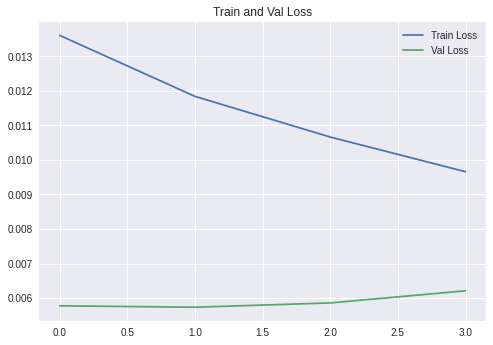

In [ ]:
#参数
save_model='long_term_model_y1.h5'#保存模型
#运行
myModel = long_term_model()#建立模型
train_model(x,y)#模型训练

##1.3 展示结果

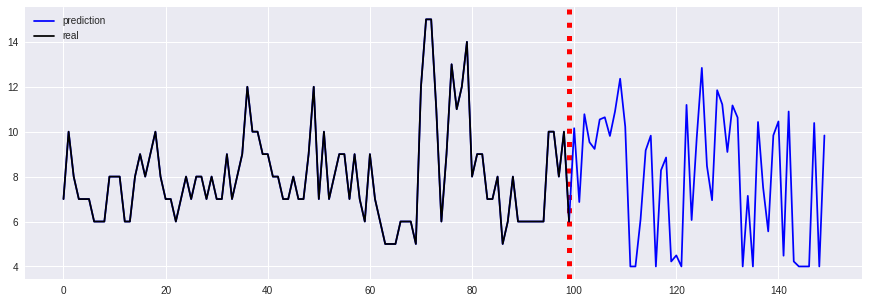

In [ ]:
def easy_result(y_test_pred,y_show):
  y_test_pred=np.reshape(y_test_pred, (-1,1)) 
  y_test_pred= mm_y.inverse_transform(y_test_pred)
  y_test_pred=y_test_pred[:,0]
  pd.DataFrame(y_test_pred).to_csv('y1_result.csv')
  #画图
  y_pred=np.hstack([y_show,y_test_pred])
  plt.figure(figsize=(15, 5))
  plt.axvline(len(y_show)-1, linestyle="dotted", linewidth=5, color='r')
  plt.plot(y_pred,label="prediction", color="b")
  plt.plot(y_show,label="real", color="k")
  plt.legend(loc="upper left")
  plt.show()

myModel.load_weights(save_model) # 加载最好的训练结果
y_test_pred=myModel.predict(x_test)
easy_result(y_test_pred,y_show)#输出评价指标

# 2 读取数据 预测y2

In [ ]:
#设置参数
choose_y=2#选择预测第几个标签
x,y,x_test,y_show,feature_num,mm_y=read_data()

The Data:
       降水量(0.1mm)  平均气压(0.1hPa)  平均相对湿度(1%)  ...  日最低气温(0.1℃)  平均风速(0.1m/s)  pm2.5
2216         0.0         10282          69  ...           22            19     73
2217         0.0         10255          80  ...           -8            14     75
2218        20.0         10208          85  ...          102            21     41
2219         0.0         10269          81  ...           58            20     76
2220         0.0         10376          60  ...            2            35     17

[5 rows x 7 columns]
数据集长度： 2221
数据集shape： (2160, 12, 6) (2160, 50) (1, 12, 6) (100,)


##1.2 训练模型

Model: "functional_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 12, 6)]           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            112       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1, 16)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 16)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 1, 16)             272       
_________________________________________________________________
dense_33 (Dense)             (None, 1, 50)             850       
Total params: 1,234
Trainable params: 1,234
Non-trainable params: 0
___________________________________________________

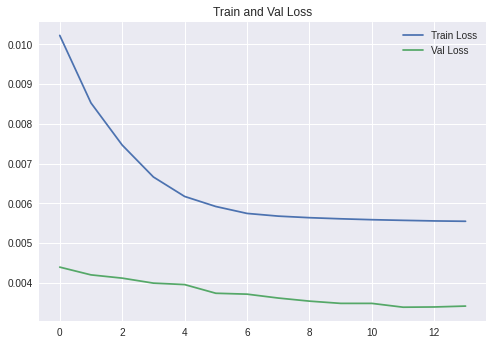

In [ ]:
#参数
save_model='long_term_model_y2.h5'#保存模型
#运行
myModel = long_term_model()#建立模型
train_model(x,y)#模型训练

##1.3 展示结果

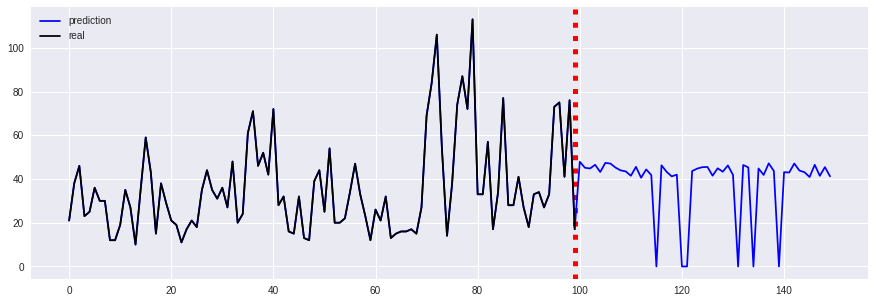

In [ ]:
def easy_result(y_test_pred,y_show):
  y_test_pred=np.reshape(y_test_pred, (-1,1)) 
  y_test_pred= mm_y.inverse_transform(y_test_pred)
  y_test_pred=y_test_pred[:,0]
  pd.DataFrame(y_test_pred).to_csv('y2_result.csv')
  #画图
  y_pred=np.hstack([y_show,y_test_pred])
  plt.figure(figsize=(15, 5))
  plt.axvline(len(y_show)-1, linestyle="dotted", linewidth=5, color='r')
  plt.plot(y_pred,label="prediction", color="b")
  plt.plot(y_show,label="real", color="k")
  plt.legend(loc="upper left")
  plt.show()

myModel.load_weights(save_model) # 加载最好的训练结果
y_test_pred=myModel.predict(x_test)
easy_result(y_test_pred,y_show)#输出评价指标